In [1]:
import os,glob,shutil,pickle,cv2,re,time
import numpy as np
import scipy as sp
from sklearn.metrics import pairwise_distances

import os
os.sys.path.append("../utilities/")
from itertools import combinations
import support_utility_openvino

# from fuzzywuzzy import fuzz

In [2]:
detection_model_path = '/media/prateek/shared_space/DATA_N_MODELS/useful_models/helmet_vest/2021_06_18_person_detection/model.xml'
device = 'CPU'
output_support = support_utility_openvino.create_plot()

In [3]:
import matplotlib.pyplot as plt
import IPython.display as Disp
import ipywidgets as widgets

class bbox_select():
    %matplotlib notebook



    def __init__(self,im):
        self.im = im
        self.selected_points = []
        self.fig,ax = plt.subplots()
        self.img = ax.imshow(self.im.copy())
        self.ka = self.fig.canvas.mpl_connect('button_press_event', self.onclick)
        disconnect_button = widgets.Button(description="Disconnect mpl")
        Disp.display(disconnect_button)
        disconnect_button.on_click(self.disconnect_mpl)


        
    def poly_img(self,img,pts):
        pts = np.array(pts, np.int32)
        pts = pts.reshape((-1,1,2))
        cv2.polylines(img,[pts],True,(0,255,255),4)
        return img

    def onclick(self, event):
    #display(str(event))
        self.selected_points.append([event.xdata,event.ydata])
        if len(self.selected_points)>1:
            self.fig
            self.img.set_data(self.poly_img(self.im.copy(),self.selected_points))
    def disconnect_mpl(self,_):
        self.fig.canvas.mpl_disconnect(self.ka)

        
            

In [4]:
def poly_intersection_shapely(pt1,pt2,intersection_threshold=.5):
    """
    bool : return True or False
    """
    p1 = Polygon(pt1)
    p2 = Polygon(pt2)
    intersection_area = p1.intersection(p2).area
    if intersection_area/p2.area>intersection_threshold:
        return True
    return False

In [5]:
def filter_result_bbox(frame,result,thresh=.4,resolution_thresh_range = None):
    initial_w,initial_h = frame.shape[1],frame.shape[0]
    res_filt =  result[np.where(result[:,:,:,2]>thresh)]
    res_filt = res_filt[np.min(res_filt,axis=1)>=0]
    if resolution_thresh_range is not None:
        res_filt = output_support.resolution_filter(res_filt,resolution_thresh_range)
    class_ids = res_filt[:,1].astype(int)
    bboxes = np.multiply([[initial_w,initial_h,initial_w,initial_h]],(res_filt[:,3:])).astype('int')
    return bboxes,res_filt

In [6]:
person_detection = support_utility_openvino.async_infer(4)
person_detection.load_model(model_path=detection_model_path,device=device)

Available Devices :  ['CPU', 'GNA', 'GPU']
OPTIMIZATION_CAPABILITIES for CPU:  ['FP32', 'FP16', 'INT8', 'BIN']
model inputs : dict_keys(['image'])
model outputs :  dict_keys(['detection_out'])


In [7]:
channel = "/media/prateek/prateek_space/helmet_n_vest/test_data/stacker_bay_hot_mill_side_view/stacker_bay_hot_mill_view-1/Embedded Net DVR_10.36.12.113_8_20190907093423_20190907093436_1568194195452.mp4"
channel = "/media/prateek/prateek_space/helmet_n_vest/test_data/2019_09_12_Taloja_video_data/2019-09-12/annealing_view/comb_output.mp4"
channel = "/media/prateek/shared_space/DATA_N_MODELS/useful_vids/general/veraval/social_distancing/Chemical road_IP Camera3_Chemical road_20190831095808_20190831095934_80790759.mp4"

<IPython.core.display.Javascript object>


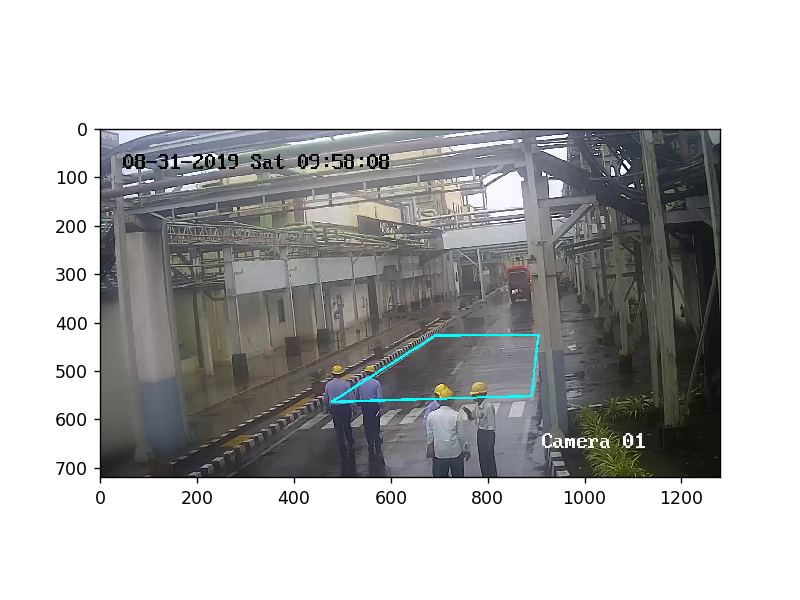

Button(description='Disconnect mpl', style=ButtonStyle())

In [8]:
cap = cv2.VideoCapture(channel)
ret,frame = cap.read()
bs = bbox_select(cv2.cvtColor(frame,cv2.COLOR_BGR2RGB))

In [13]:
bs.selected_points

[[691.6289850050402, 428.66124306955646],
 [905.8225333921371, 426.0805979082661],
 [890.3386624243951, 552.532210811492],
 [477.4354366179436, 565.4354366179434]]

In [14]:
width = 800
height = 1100


final_points = [[0,0],[width,0],[width,height],[0,height]]


M = cv2.getPerspectiveTransform(np.float32(bs.selected_points),np.float32(final_points))

In [15]:
def create_distance_arrow(frame, st_pt,end_pt,text,font=cv2.FONT_HERSHEY_SIMPLEX,font_scale=.8,font_thickness=2,font_color=(0,0,0),line_color=(255,255,255),display_category = False):
    """
    frame on which distance matrix have to be created
    st_pt : start point of line
    end_pt : end point of line
    text : text to write
    
    """
    
    (text_width, text_height) = cv2.getTextSize(text, font, fontScale=font_scale, thickness=font_thickness)[0]
    if display_category:
        ## assuming distance in meter and text is distance
        distance = int(re.findall(r'\d+',text)[0] )
        if distance<100:
            line_color = (0,0,255)
        elif distance<200:
            line_color = (0,255,255)
        else :
            line_color = (0,255,0)
    op_frame = cv2.line(frame,tuple(st_pt),tuple(end_pt),line_color,font_thickness)
    op_frame = cv2.putText(op_frame, text,tuple(((st_pt+end_pt)/2+np.array([0,text_height])).astype(int)) , font,  font_scale, font_color, font_thickness, cv2.LINE_AA) 
    return op_frame
    

In [16]:
def get_closest_comb(bbox1,bbox2):
    pts1 = np.array([[bbox1[0],bbox1[3]],[bbox1[2],bbox1[3]]])
    pts2 = np.array([[bbox2[0],bbox2[3]],[bbox2[2],bbox2[3]]])
    D = pairwise_distances(pts1,pts2,metric='euclidean')
    coords = np.unravel_index(D.argmin(), D.shape)
    return np.array([pts1[coords[0]],pts2[coords[1]]])

In [17]:
def get_distance_mat(bboxes,M):
    """
    bboxes :  bbox  array
    M : Transformation matrix
    """
    combs = list(combinations(list(range(bboxes.shape[0])),2))
    D = np.zeros((bboxes.shape[0],bboxes.shape[0]))
    for idx,comb in enumerate(combs):
        pts_comb= get_closest_comb(bboxes[comb[0]],bboxes[comb[1]])
        pts_comb_trans = cv2.perspectiveTransform(np.float32([pts_comb]),M).squeeze()
        dist = int(sp.spatial.distance.euclidean(pts_comb_trans[0],pts_comb_trans[1]))
        D[(comb[1],comb[0])] = dist
        D[(comb[0],comb[1])] = dist
    return D
        
        
    
    

In [18]:
def write_distance_frame(frame,bboxes,M,units ="cm"):
    """
    frame : frame on which distance have to be write
    bboxes :  bbox  array
    M : Transformation matrix
    """
    combs = list(combinations(list(range(bboxes.shape[0])),2))
    for idx,comb in enumerate(combs):
        pts_comb= get_closest_comb(bboxes[comb[0]],bboxes[comb[1]])
        pts_comb_trans = cv2.perspectiveTransform(np.float32([pts_comb]),M).squeeze()
        dist = int(sp.spatial.distance.euclidean(pts_comb_trans[0],pts_comb_trans[1]))
        text = str(dist) 
        if units is not None:
            text = text + units
        frame = create_distance_arrow(frame,pts_comb[0],pts_comb[1],text,display_category = True)
    return frame

In [16]:
channel = "/media/prateek/prateek_space/helmet_n_vest/test_data/2019_09_12_Taloja_video_data/2019-09-12/stacker _bay_hot_mill_side_view/Embedded Net DVR_10.36.12.113_8_20190909164740_20190909164812_1568193594477.mp4"

In [19]:
res_thresh = output_support.get_resolution_thresh(frame)

In [16]:
def rotate_image(image, angle):
    image_center = tuple(np.array(image.shape[1::-1]) / 2)
    rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
    result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
    return result

In [21]:
write_video = False
show_bbox = False
fps_async = []
person_detection.reinit_model()
# for idx,channel in enumerate(glob.glob("/media/prateek/prateek_space/helmet_n_vest/test_data/2019_09_12_Taloja_video_data/2019-09-12/stacker _bay_hot_mill_side_view/*")):
cap = cv2.VideoCapture(channel)
cap.set(1,0)
thresh = .5
# res_thresh = [.00005,.03]
cv2.namedWindow("preview",cv2.WINDOW_NORMAL)
person_detection.reinit_model()
if write_video:
    fourcc = cv2.VideoWriter_fourcc(*'x264')
    videowriter = cv2.VideoWriter("../output_vids/distance_measurement/textile/"+"worst"+".mp4",fourcc, 30, (int(cap.get(3)),int(cap.get(4))))
while True:
    ret, frame = cap.read()
#     frame = rotate_image(frame,+10)

    if not ret:
        break
    t0 = time.time()    
    person_detection.predict(frame)
    if person_detection.frame_processed>person_detection.num_requests:
        frame,attr,res = person_detection.postprocess_op()

        bboxes,res_filt = filter_result_bbox(frame,res[0],thresh = thresh,resolution_thresh_range=res_thresh)
        if bboxes.shape[0]>1:
    #         D =pairwise_distances(cv2.perspectiveTransform(np.float32([bboxes[:,2:]]),M).squeeze()).astype(int)
            frame = write_distance_frame(frame,bboxes,M)
        t1 = time.time()    
        fps_async.append([len(bboxes),(t1-t0)])
        if show_bbox:
            frame = cv2.polylines(frame,[np.reshape(bs.selected_points,(-1,1,2)).astype('int32')],True,(255,255,0),2,cv2.LINE_AA)


        frame = output_support.label_obj_detection(frame,np.expand_dims(res_filt,axis=[0,1]),labels=['person'],thresh=thresh)
#         dst = cv2.warpPerspective(frame,M,(int(width),int(height)))
        if write_video:
            videowriter.write(frame)
        cv2.imshow("preview",frame)
        k = cv2.waitKey(0)
        if k==ord('q'):
            break

if write_video:
    videowriter.release()
cv2.destroyAllWindows()
cap.release()

## ---------------------------------------for paper--------------------

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-dark')


In [ ]:
df_sync = pd.DataFrame(fps_sync)
df_async = pd.DataFrame(fps_async)

In [ ]:
l_sync = {}
for i in range(1,6):
    l_sync[i] = pd.DataFrame(list(map(lambda x: 1/x[1], filter(lambda x: x[0]==i, fps_sync))))
    
    
l_async = {}
for i in range(1,6):
    l_async[i] = pd.DataFrame(list(map(lambda x: 1/x[1], filter(lambda x: x[0]==i, fps_async))))
    
    
df_sync_concat = pd.concat(l_sync,axis=1).droplevel(1,axis=1)
df_async_concat = pd.concat(l_async,axis=1).droplevel(1,axis=1)


In [ ]:
ax = df_sync_concat.plot(kind='box')
ax.set_xlabel("number of person in frame")
ax.set_ylabel("Throughput FPS(sync)")
ax.figure.savefig("sync_fps.jpg",dpi=199)

In [ ]:
ax = df_async_concat.plot(kind='box')
ax.set_xlabel("number of person in frame")
ax.set_ylabel("Throughput FPS(async)")
ax.figure.savefig("async_fps.jpg",dpi=199)

In [ ]:
pd.DataFrame({"sync":df_sync_concat.median(),"async":df_async_concat.median()})

In [ ]:
pd.concat([df_sync_grp.loc[0],df_sync_grp.loc[1]],ignore_index=True,axis=1)

In [ ]:
df_sync_grp = df_sync.groupby(0).agg(lambda x : list(1/x))
df_async_grp = df_async.groupby(0).agg(lambda x : list(1/x))

In [ ]:
df_async_grp

In [ ]:
df_sync_grp.plot(kind='box')

In [ ]:
cv2.imshow("preview",dst)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [ ]:
cv2.imwrite("output_vids/distance_measurement/sample_image_converted1.jpg",dst)

In [ ]:
cv2.imwrite("output_vids/distance_measurement/original_image4.jpg",frame_op)

In [ ]:
cv2.resize(dst,tuple(reversed(frame.shape[:2])))

In [ ]:
frame.shape

In [ ]:
cv2.resize(dst,frame.shape[:2]).shape

In [ ]:
np.reshape(bs.selected_points,(-1,1,2)).astype('int32')

In [ ]:
    frame_op = cv2.polylines(frame_op,[np.reshape(bs.selected_points,(-1,1,2)).astype('int32')],True,(0,255,255),1,cv2.LINE_4)
